# Disaster Tweets Prediction using Neural Networks

This project explores the Kaggle Disaster Tweets dataset and aims to predict whether a tweet is about a real disaster or not. The dataset contains 10,000 tweets that were hand classified. The goal is to build a machine learning model that can predict which tweets are about a real disaster and which are not.

This project will focus on using Neural Networks to build the model. The project will use the `tensorflow` and `keras` libraries to build the model.  The `sklearn` library will be used for data preprocessing and evaluation.

The project is divided into the following sections:

1. Data Exploration (EDA)
2. Data Preprocessing
3. Model Building
4. Model Evaluation
5. Model Prediction on Test Data
6. Conclusion

In [196]:
# Standard library imports
import re

# Data manipulation and numeric computing
import numpy as np
import pandas as pd

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine learning and NLP
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

# Deep learning
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (Bidirectional, Dense, Dropout, Embedding, GRU,
                                     GlobalMaxPooling1D, Input, LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_tuner import HyperModel, RandomSearch

# Data Exploration (EDA)

The first step is to load the data and perform some basic data inspection. The data is loaded into a pandas dataframe and the first few rows are displayed to get an idea of the data. The data contains the following columns:

1. id: A unique identifier for each tweet
2. keyword: A keyword from the tweet
3. location: The location the tweet was sent from
4. text: The text of the tweet
5. target: Whether the tweet is about a real disaster (1) or not (0)

In [197]:
# Read in the training and test data
tweets = pd.read_csv("./nlp-getting-started/train.csv")
kaggle_test_set = pd.read_csv("./nlp-getting-started/test.csv")
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [198]:
# Print out the counts of the target variable
tweets['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

There is a class imbalance in the data, with more tweets about non-disasters than disasters. This will be taken into account when building the model.

In [199]:
# Check for missing values in the dataset
print("Missing values in the dataset: ")
print(tweets.isnull().sum())
print("\n")
print(f"Shape of training data: {tweets.shape}")
print("\n")
print(f"Shape of test data: {kaggle_test_set.shape}")

Missing values in the dataset: 
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Shape of training data: (7613, 5)


Shape of test data: (3263, 4)


From the data description, we can see that the keyword and location columns have missing values. In this project, we will only use the text column to build the model, so we will not be using these columns. We primarily want to inspect model performance on understanding nuances in text rather than cateogorical indicators such as location or keywords.

In [200]:
# Print out the most common location and keyword values
print(tweets['location'].value_counts().head(25))

print(tweets['keyword'].value_counts().head(25))

location
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Mumbai               22
Washington, DC       21
Kenya                20
Worldwide            19
Australia            18
Chicago, IL          18
California           17
Everywhere           15
New York, NY         15
California, USA      15
Florida              14
San Francisco        14
United Kingdom       14
Los Angeles          13
Indonesia            13
Washington, D.C.     13
Name: count, dtype: int64
keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         

As seen above the top locations are USA, New York, United States, London, Canada, etc. The top keywords are fatalities, armageddon, deluge, body bag, etc. These are interesting findings, but we will not be using these columns for the model.

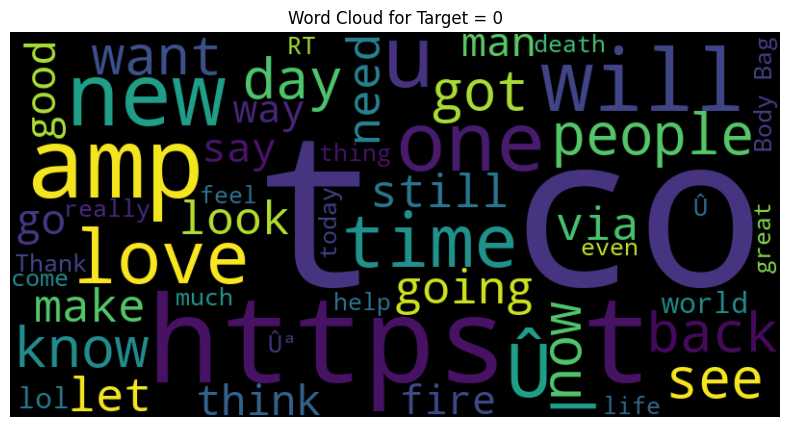

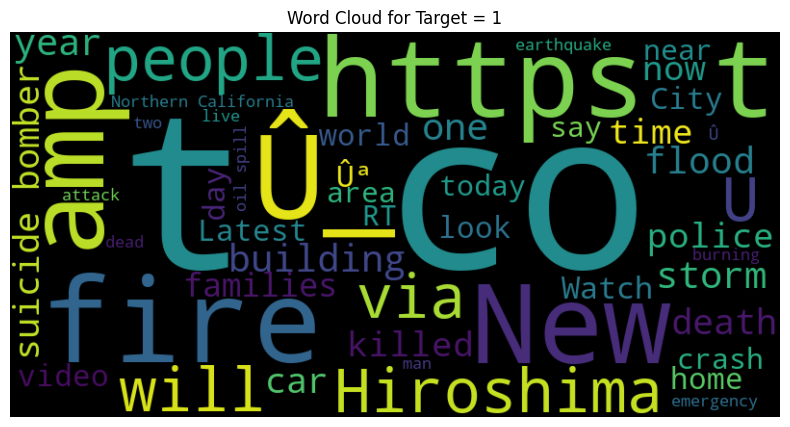

In [201]:
# Generate a Word Cloud to visualize the most common words in the tweets for each target class
tweets_target_0 = tweets[tweets['target'] == 0]['text']
tweets_target_1 = tweets[tweets['target'] == 1]['text']

# Function to generate and display word cloud
def generate_word_cloud(text, title):
    wc = WordCloud(width=800, height=400, max_words=50).generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word cloud for target = 0
generate_word_cloud(tweets_target_0, 'Word Cloud for Target = 0')

# Generate word cloud for target = 1
generate_word_cloud(tweets_target_1, 'Word Cloud for Target = 1')

Within the word cloud above we can see some similar words in both classes, we are hoping that the model is able to distinguish the context in which these words are being used. 

# Step 2. Data Preprocessing for model building

The next step is to preprocess the data for model building. This involves the following steps:

1. Text Cleaning: The text data in the tweets needs to be cleaned before it can be used for model building. This involves removing special characters, numbers, and stopwords, and converting the text to lowercase.
2. Tokenization: The cleaned text data needs to be tokenized into words so that it can be used for model building.
3. Padding: The tokenized text data needs to be padded so that all sequences are of the same length.
4. Train-Test Split: The data needs to be split into training and testing sets for model building and evaluation.

In [202]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text Cleaning Function
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # remove non-letters
    text = re.sub(r'\s+', ' ', text)  # remove extra whitespace
    text = text.lower()  # convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text

tweets['text'] = tweets['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerjensen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Example tweets after cleaning the text with regex and removing stopwords:


In [203]:
tweets['text'].tail(), tweets['target'].tail()

(7608    two giant cranes holding bridge collapse nearb...
 7609    aria ahrary thetawniest control wild fires cal...
 7610                                utc km volcano hawaii
 7611    police investigating e bike collided car littl...
 7612    latest homes razed northern california wildfir...
 Name: text, dtype: object,
 7608    1
 7609    1
 7610    1
 7611    1
 7612    1
 Name: target, dtype: int64)

Tokenize the data to convert the text data into numerical data that can be used for model building. The `Tokenizer` class from the `keras.preprocessing.text` module is used to tokenize the text data. The `fit_on_texts` method is used to fit the tokenizer on the text data, and the `texts_to_sequences` method is used to convert the text data into sequences of integers.

For our embeddings we use Glove embeddings which are pre-trained word vectors that can be used to create word embeddings for our text data. We use the 300-dimensional Glove embeddings in this project.

In [204]:
# Text Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets['text'])
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweets['text'])

# Padding the sequences
max_length = max([len(s.split()) for s in tweets['text']])
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Load GloVe embeddings
embedding_dict = {}
with open('./glove.6B/glove.6B.300d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vectors

# Create embedding matrix
embedding_dim = 300  
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)    

Now that we have cleaned up the text we will now analyze the length of the tweets to inspect the distribution of the tweet lengths. 

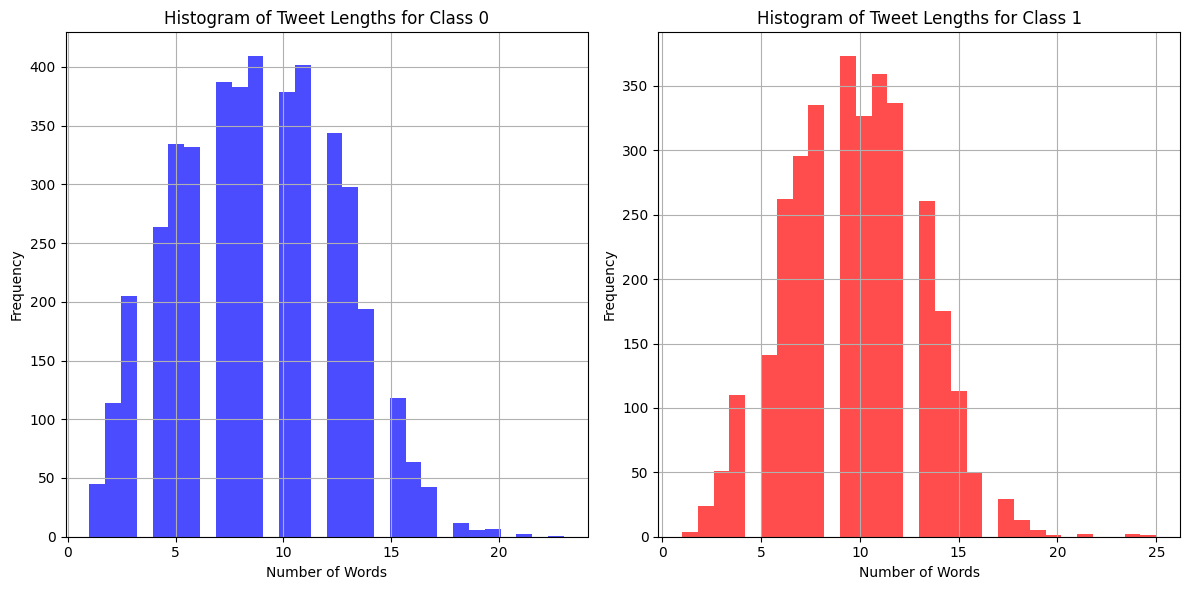

In [205]:
# Plot the distribution of tweet lengths
tweets['text_length'] = tweets['text'].apply(lambda x: len(x.split()))  


plt.figure(figsize=(12, 6))
# Histogram for class 0
plt.subplot(1, 2, 1) 
plt.hist(tweets[tweets['target'] == 0]['text_length'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Tweet Lengths for Class 0')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for class 1
plt.subplot(1, 2, 2)  
plt.hist(tweets[tweets['target'] == 1]['text_length'], bins=30, color='red', alpha=0.7)
plt.title('Histogram of Tweet Lengths for Class 1')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

Above shows the distribution of the length of the tweets for each class. 

Split the data for training the models. 

In [206]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_docs, tweets['target'], test_size=0.2, random_state=12)

# Convert the target variables to numpy arrays
y_train_np = y_train.values
y_test_np = y_test.values 

This dataset is imbalanced for the target variable. In this we will use the class weights in the training to help with the training of the model.

In [207]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)

# Create dictionary of class weights
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class weights:", class_weight_dict)

Class weights: {0: 0.8823529411764706, 1: 1.1538461538461537}


# Step 3A. Model Building LSTM Model

The next step is to build the model using Neural Networks. The model will be built using the `tensorflow` and `keras` libraries. The model architecture will consist of an Embedding layer, followed by LSTM layers, and a Dense layer for classification. We will explore several architectures and hyperparameters to find the best model.


The first model uses a simple LSTM model with the following architecture:

1. Embedding layer: This layer is used to create word embeddings for the text data. The embedding layer is initialized with the Glove embeddings and is set to be non-trainable.
2. LSTM layer: This layer is used to process the sequence data. The LSTM layer has 100 units and returns the output sequence. There is a second LSTM layer with 100 units.
3. Dense Layer with 50 Units and Relu activation
4. Dense Layer with 1 Unit and Sigmoid activation

The model is compiled with the binary crossentropy loss function and the Adam optimizer. The model is trained on the training data for 5 epochs with a batch size of 12.

Epoch 1/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7532 - loss: 0.5189 - val_accuracy: 0.7997 - val_loss: 0.4561 - learning_rate: 0.0010
Epoch 2/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8115 - loss: 0.4267 - val_accuracy: 0.7833 - val_loss: 0.4543 - learning_rate: 0.0010
Epoch 3/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8383 - loss: 0.3880 - val_accuracy: 0.8024 - val_loss: 0.4670 - learning_rate: 0.0010
Epoch 4/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8713 - loss: 0.3409 - val_accuracy: 0.8129 - val_loss: 0.4476 - learning_rate: 0.0010
Epoch 5/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8766 - loss: 0.3166 - val_accuracy: 0.8142 - val_loss: 0.4562 - learning_rate: 0.0010


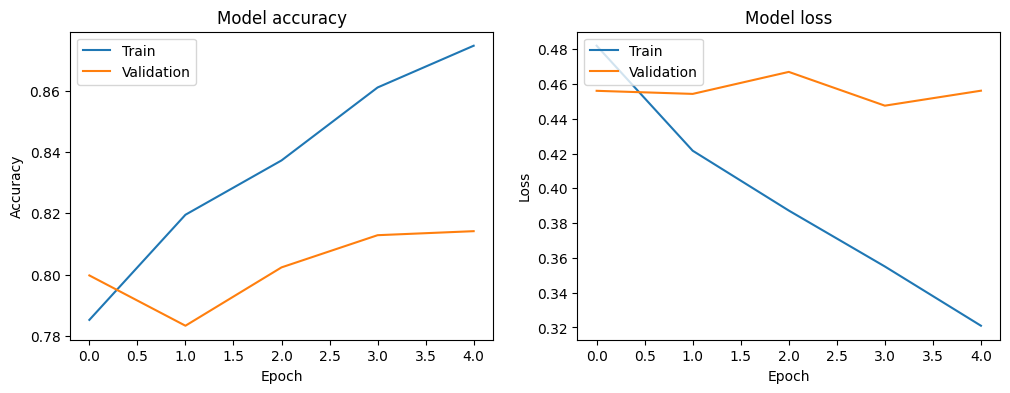

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       891
           1       0.81      0.72      0.76       632

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



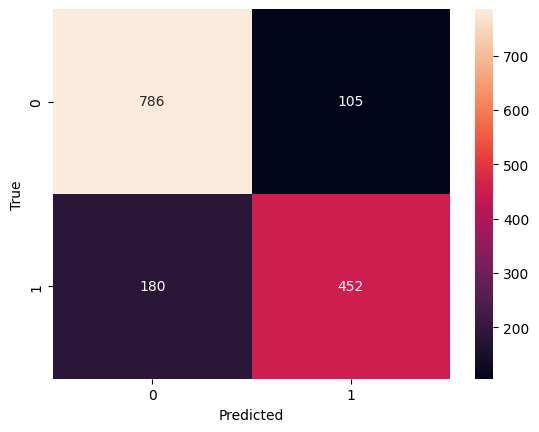

In [208]:
def build_lstm(vocab_size, max_length, embedding_dim, embedding_matrix):
    model = Sequential()
    model.add(Input(shape=(max_length,)))
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model using the Glove embeddings
lstm_model = build_lstm(vocab_size, max_length, embedding_dim, embedding_matrix)

# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Then, when fitting the model:
history = lstm_model.fit(
    X_train, y_train_np, 
    epochs=5,
    batch_size=12,
    validation_data=(X_test, y_test_np), 
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)


# Plot accuracy and loss for training and validation sets function to be used for all models
def plot_model(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


plot_model(history)


# Model evaluation function to be used on all models for evaluation
def model_evaluation(model, X_test, y_test):

    # Classification Report
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred).astype(int)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

model_evaluation(lstm_model, X_test, y_test)

# 3B Building a Deeper LSTM Model 

This model has many more layers than our first model. We have added more LSTM layers and Dropout layers to prevent overfitting. The LTSM starts with 128 units and then decreases to 64 units. between the LSTM layers we have added a dropout layer to prevent overfitting. Then we go into MaxPooling1D and then a Dense layer with 64 units. The final LSTM has 32 units followed by the Dense layer with 1 unit for classification.

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 25, 300)        │     4,820,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 25, 256)        │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 25, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,434,717 (20.73 MB)

 Trainable params: 614,017 (2.34 MB)

 Non-trainable params: 4,820,700 (18.39 MB)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7219 - loss: 0.5722 - val_accuracy: 0.7978 - val_loss: 0.4774 - learning_rate: 0.0100
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.8215 - loss: 0.4433 - val_accuracy: 0.8076 - val_loss: 0.4513 - learning_rate: 0.0100
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.8463 - loss: 0.3914 - val_accuracy: 0.7873 - val_loss: 0.4648 - learning_rate: 0.0100
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.8789 - loss: 0.3291 - val_accuracy: 0.7722 - val_loss: 0.5626 - learning_rate: 0.0100
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.9008 - loss: 0.2746 - val_accuracy: 0.7623 - val_loss: 0.5350 - learning_rate: 0.0100


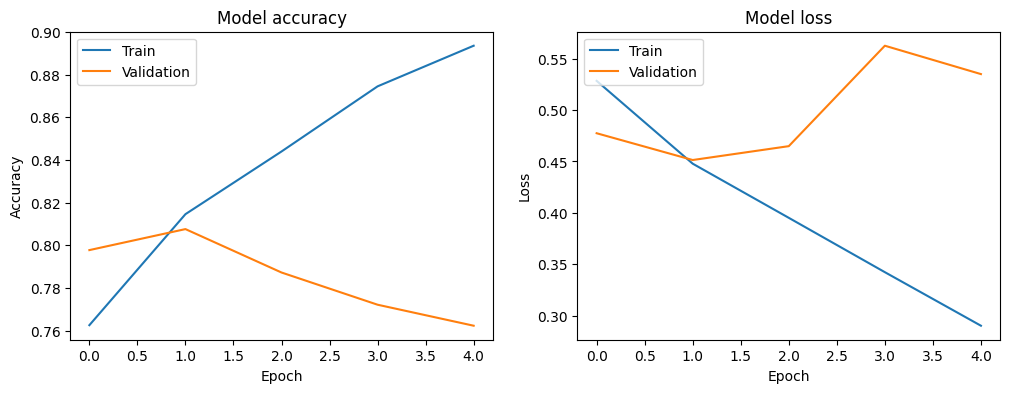

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       891
           1       0.77      0.73      0.75       632

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



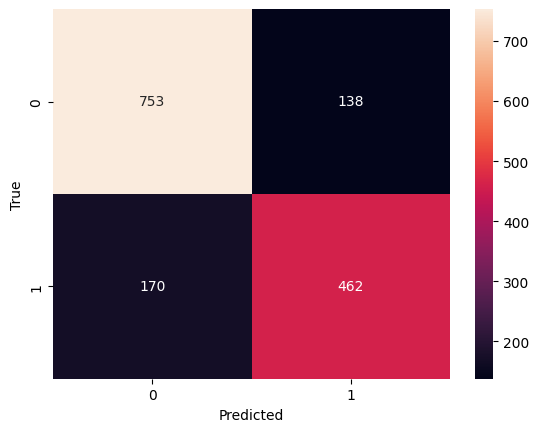

In [209]:
# Deeper LSTM model with Bidirectional LSTM layers
def build_advanced_lstm(vocab_size, max_length, embedding_dim, embedding_matrix):
    model = Sequential()
    model.add(Input(shape=(max_length,)))
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))
    
    # Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    
    # Global Max Pooling
    model.add(GlobalMaxPooling1D())
    
    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
large_lstm_model = build_advanced_lstm(vocab_size, max_length, embedding_dim, embedding_matrix)

# Print model summary
large_lstm_model.summary()

# Train the model
history = large_lstm_model.fit(
    X_train, y_train_np,
    epochs=5,
    batch_size=32,  
    validation_data=(X_test, y_test_np),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

plot_model(history)
model_evaluation(large_lstm_model, X_test, y_test)

# 3C Building a GRU Model 

The final model is a GRU variation of the last model but using GRU units instead of LSTM units. The GRU Units provide a simpler and faster alternative to LSTM units. The model has 128 GRU units followed by a Dense layer with 64 units. The final GRU layer has 32 units followed by the Dense layer with 1 unit for classification.

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 25, 300)        │     4,820,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 25, 256)        │       330,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 25, 128)        │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,284,957 (20.16 MB)

 Trainable params: 464,257 (1.77 MB)

 Non-trainable params: 4,820,700 (18.39 MB)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.6936 - loss: 0.5871 - val_accuracy: 0.8102 - val_loss: 0.4539 - learning_rate: 0.0100
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.8222 - loss: 0.4311 - val_accuracy: 0.8162 - val_loss: 0.4496 - learning_rate: 0.0100
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.8442 - loss: 0.3976 - val_accuracy: 0.8122 - val_loss: 0.4528 - learning_rate: 0.0100
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8637 - loss: 0.3729 - val_accuracy: 0.8175 - val_loss: 0.4751 - learning_rate: 0.0100
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.8768 - loss: 0.3316 - val_accuracy: 0.7912 - val_loss: 0.4917 - learning_rate: 0.0100


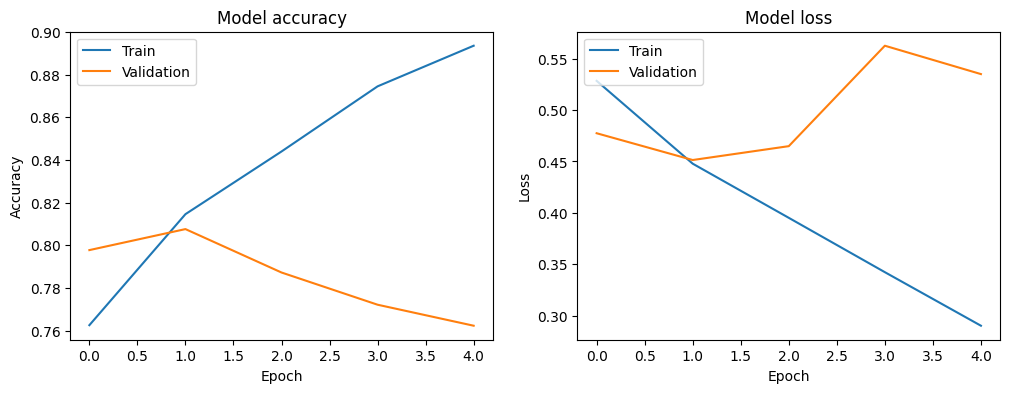

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       891
           1       0.84      0.67      0.75       632

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523



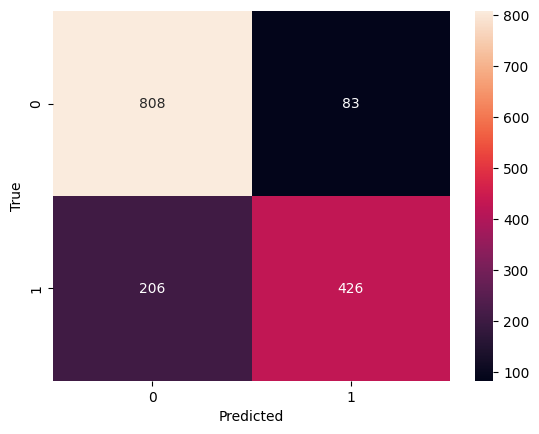

In [210]:
# Build a GRU model
def build_gru_model(vocab_size, max_length, embedding_dim, embedding_matrix):
    model = Sequential()
    model.add(Input(shape=(max_length,)))
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))
    
    # Bidirectional GRU layers
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(GRU(64, return_sequences=True)))
    model.add(Dropout(0.3))
    
    # Global Max Pooling
    model.add(GlobalMaxPooling1D())
    
    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the GRU model
gru_model = build_gru_model(vocab_size, max_length, embedding_dim, embedding_matrix)

# Print model summary
gru_model.summary()

# Train the model
history_gru = gru_model.fit(
    X_train, y_train_np,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test_np),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

plot_model(history)
model_evaluation(gru_model, X_test, y_test)

# My Chosen Model Hyperparameter Tuning

After analyzing the results of my previous models, I have observed that the simplest LSTM model demonstrated the best accuracy. Now, I want to see if I can further improve this model through hyperparameter tuning.

For this task, I have decided to utilize the keras_tuner package. This will allow me to systematically explore various model parameters and find the optimal configuration.

In my hyperparameter tuning process, I am focusing on the following parameters:

1. Number of LSTM layers: I am testing configurations with 1 to 3 layers.
2. Number of units in each LSTM layer: I am exploring a range from 32 to 256 units.
3. Number of dense layers: I am considering adding 0 to 2 dense layers.
4. Number of units in each dense layer: If I include dense layers, I am testing between 16 to 128 units.
5. Learning rate: I am searching within a range of 1e-4 to 1e-2.

To ensure a robust evaluation of my model's performance, I have implemented a perform_cross_validation function. This function uses StratifiedKFold for 5-fold cross validation, which will give me a more reliable estimate of how well my model generalizes.

For the hyperparameter search itself, I am employing Keras Tuner's RandomSearch. This method will help me efficiently explore the hyperparameter space and identify promising configurations.

Once I have found the best hyperparameters, I plan to perform another round of cross validation with this optimized model. This step will provide me with a more accurate assessment of its performance.

As a final step, I will train a model using the best hyperparameters on my full training set. I will then evaluate this model on my test set to get a final measure of its performance.

By following this approach, I am aiming to fine tune my LSTM model and potentially improve its accuracy beyond what I achieved with the simpler version. Let us see what improvements I can make!

Reloading Tuner from lstm_tuning/lstm_hyperparameters/tuner0.json
Best Hyperparameters:
num_lstm_layers: 1
lstm_units_0: 32
num_dense_layers: 0
learning_rate: 0.0006666393107144415
lstm_units_1: 224
dense_units_0: 32
lstm_units_2: 64
dense_units_1: 64
Fold 1
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8241 - loss: 0.4073
Fold 1 accuracy: 0.8054
Fold 2
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.3842
Fold 2 accuracy: 0.8571
Fold 3
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8793 - loss: 0.3086
Fold 3 accuracy: 0.8768
Fold 4
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8774 - loss: 0.3207
Fold 4 accuracy: 0.8826
Fold 5
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8848 - loss: 0.2743
Fold 5 accuracy: 0.9015
Mean accuracy: 0.8647 (+/- 0.0328)
Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6761 - loss: 0.6007 - val_accuracy: 0.7890 - val_loss: 0.4811 - learning_rate: 6.6664e-04
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━

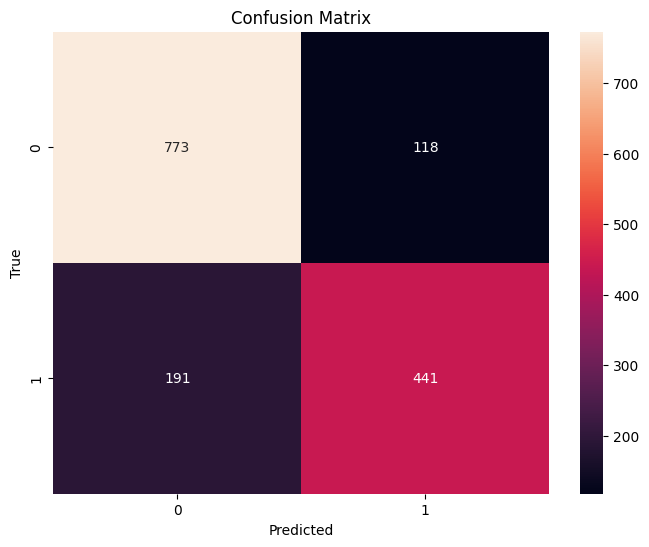

In [211]:
# Class to tune and define the best LSTM Model to use going forward using the original architecture
class LSTMHyperModel(HyperModel):
    def __init__(self, vocab_size, max_length, embedding_dim, embedding_matrix):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.embedding_matrix = embedding_matrix

    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(self.max_length,)))
        model.add(Embedding(self.vocab_size, self.embedding_dim, weights=[self.embedding_matrix], trainable=False))
        
        # Tune the number of LSTM layers 
        for i in range(hp.Int('num_lstm_layers', 1, 3)):
            model.add(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32),
                           return_sequences=True if i < hp.Int('num_lstm_layers', 1, 3) - 1 else False))
        
        # Tune the number of dense layers 
        for i in range(hp.Int('num_dense_layers', 0, 2)):
            model.add(Dense(units=hp.Int(f'dense_units_{i}', min_value=16, max_value=128, step=16),
                            activation='relu'))
        
        model.add(Dense(1, activation='sigmoid'))
        
        # Tune the learning rate
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        return model

def perform_cross_validation(model, X, y, n_splits=5):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):
        print(f"Fold {fold}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = dict(enumerate(class_weights))
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[reduce_lr, early_stopping],
            class_weight=class_weight_dict,
            verbose=0
        )
        
        scores.append(model.evaluate(X_val, y_val)[1])
        print(f"Fold {fold} accuracy: {scores[-1]:.4f}")
    
    print(f"Mean accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    return np.mean(scores)

tuner = RandomSearch(
    LSTMHyperModel(vocab_size, max_length, embedding_dim, embedding_matrix),
    objective='val_accuracy',
    max_trials=10,
    directory='lstm_tuning',
    project_name='lstm_hyperparameters'
)

tuner.search(X_train, y_train,
             epochs=20,
             validation_split=0.2,
             callbacks=[EarlyStopping('val_loss', patience=5)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Perform cross-validation with the best model
mean_accuracy = perform_cross_validation(best_model, X_train, y_train_np)

# Final evaluation on the test set
final_model = tuner.hypermodel.build(best_hps)
final_model.fit(X_train, y_train, epochs=20, validation_split=0.2,
                callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001),
                           EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

y_pred = final_model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

print("\nFinal Model Evaluation:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 5. Model Prediction on Test Data

Finally, we will use the best model to make predictions on the test data using the highest performing model. We will preprocess the test data in the same way as the training data and use the model to predict whether the tweets are about real disasters or not.

In [221]:
# Clean the test data text and combine the location and keyword columns
kaggle_test_set['cleaned_text'] = kaggle_test_set['text'].apply(clean_text)

# Tokenize and pad the sequences
test_sequences = tokenizer.texts_to_sequences(kaggle_test_set['cleaned_text'])
max_length = max([len(s.split()) for s in kaggle_test_set['text']])
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

X_test_final = X_test_padded

In [222]:
# Make predictions using trained GRU model
y_pred_prob = gru_model.predict(X_test_final)
y_pred = (y_pred_prob > 0.5).astype(int)

# Format predictions for Kaggle submission
submission = pd.DataFrame({
    'id': kaggle_test_set['id'],
    'target': y_pred.flatten()
})

# Save the submission file
submission.to_csv('gru_submission.csv', index=False)

print("Submission file created: gru_submission.csv")


print("Number of predictions:", len(submission))
print("Number of unique values in predictions:", submission['target'].nunique())
print("Sample of predictions:\n", submission.head())
print("NaN values in predictions:", submission['target'].isna().sum())

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Submission file created: gru_submission.csv
Number of predictions: 3263
Number of unique values in predictions: 2
Sample of predictions:
    id  target
0   0       1
1   2       0
2   3       1
3   9       1
4  11       1
NaN values in predictions: 0


In [223]:
# Predict on advanced_lstm model
y_pred_prob = large_lstm_model.predict(X_test_final)
y_pred = (y_pred_prob > 0.5).astype(int)

# Format predictions for Kaggle submission
submission = pd.DataFrame({
    'id': kaggle_test_set['id'],
    'target': y_pred.flatten()
})

# Save the submission file
submission.to_csv('large_lstm_submission.csv', index=False)

print("Submission file created: large_lstm_submission.csv")


print("Number of predictions:", len(submission))
print("Number of unique values in predictions:", submission['target'].nunique())
print("Sample of predictions:\n", submission.head())
print("NaN values in predictions:", submission['target'].isna().sum())

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
Submission file created: large_lstm_submission.csv
Number of predictions: 3263
Number of unique values in predictions: 2
Sample of predictions:
    id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
NaN values in predictions: 0


In [224]:
# Predict on advanced_lstm model
y_pred_prob = lstm_model.predict(X_test_final)
y_pred = (y_pred_prob > 0.5).astype(int)

# Format predictions for Kaggle submission
submission = pd.DataFrame({
    'id': kaggle_test_set['id'],
    'target': y_pred.flatten()
})

# Save the submission file
submission.to_csv('lstm_submission.csv', index=False)

print("Submission file created: lstm_submission.csv")


print("Number of predictions:", len(submission))
print("Number of unique values in predictions:", submission['target'].nunique())
print("Sample of predictions:\n", submission.head())
print("NaN values in predictions:", submission['target'].isna().sum())

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Submission file created: lstm_submission.csv
Number of predictions: 3263
Number of unique values in predictions: 2
Sample of predictions:
    id  target
0   0       0
1   2       0
2   3       1
3   9       0
4  11       1
NaN values in predictions: 0


In [225]:
# Make predictions using final LSTM model with hyperparameters tuning
y_pred_prob = final_model.predict(X_test_final)
y_pred = (y_pred_prob > 0.5).astype(int)

# Format predictions for Kaggle submission
submission = pd.DataFrame({
    'id': kaggle_test_set['id'],
    'target': y_pred.flatten()
})

# Save the submission file
submission.to_csv('lstm_final_submission.csv', index=False)

print("Submission file created: lstm_final_submission.csv")


print("Number of predictions:", len(submission))
print("Number of unique values in predictions:", submission['target'].nunique())
print("Sample of predictions:\n", submission.head())
print("NaN values in predictions:", submission['target'].isna().sum())

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Submission file created: lstm_final_submission.csv
Number of predictions: 3263
Number of unique values in predictions: 2
Sample of predictions:
    id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
NaN values in predictions: 0


![Kaggle Submission](./model-submissions.png)

# Conclusion 

The simple LSTM model had the best results on the kaggle submission. This submission had a .80324 score. The text was just analyzed using the tweets to be able to use text analysis to make decisions rather than the cateogircal locations and keywords as a bias to the performance of the text sequence understanding our models are performing. 

The hyperparameter tuning did not improve the model performance. The model was able to predict the test data. 

One thing to note on most of the models the precision and recall for both classes were pretty similar, which is indicating that our class weight was able to help the model learn the class imbalance for both classes.

Overall all of the models as the epochs increased the validation scores started to decrease, this is due to the model starting to overfit on test data. This should be considered on evaluating the model performance. In future models, transfer learning could be used to improve the model performance. This project was a good introduction to using Neural Networks for text classification.